# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 340.8 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Импорт необходимых библиотек

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [15]:
nltk.download('punkt')        
nltk.download('punkt_tab')    

[nltk_data] Downloading package punkt to /home/lanmo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/lanmo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [17]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [18]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 120000/120000 [00:12<00:00, 9906.05it/s]

Размер словаря: 11842


In [19]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [20]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [109]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    model.eval()
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Возьмем модел с семинара

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def trainer(
        model,
        train_loader,
        val_loader,
        opimizer,
        critetrion,
        epoches:int = 10,
        device:str = 'cpu'):
    train_list = []
    val_list = []

    best_score = float('inf')

    for epoch in range(epoches):
        model.to(device)
        model.train()

        train_loss = 0.0

        for batch in tqdm(train_loader,desc=f'Обучение на эпохе: {epoch}'):
            X,y =batch['input_ids'].to(device),batch['label'].to(device)
            opimizer.zero_grad()
            loss = critetrion(model(X),y)
            loss.backward()
            opimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_list.append(train_loss)
        
        #====Тут смотрим на eval======
        model.eval()
        val_loss = 0.0

        for batch in tqdm(val_loader,desc=f'Валидация на эпохе: {epoch}'):
            X,y =batch['input_ids'].to(device),batch['label'].to(device)
            loss = critetrion(model(X),y)
            val_loss += loss.item()

        
        val_loss /= len(val_loader)

        if best_score > val_loss:
            best_score = val_loss
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        val_list.append(val_loss)


        plt.plot(range(epoch+1),train_list,label = 'train')
        plt.plot(range(epoch+1),val_list,label = 'val')
        plt.legend()
        plt.show()

In [72]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  
        output, _ = self.rnn(embeddings)  

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] 
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) 
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  
        prediction = self.projection(self.non_lin(output))  

        return prediction

In [73]:
list(range(1))

[0]

In [74]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

Валидация на эпохе: 0: 100%|██████████| 157/157 [00:02<00:00, 54.43it/s]


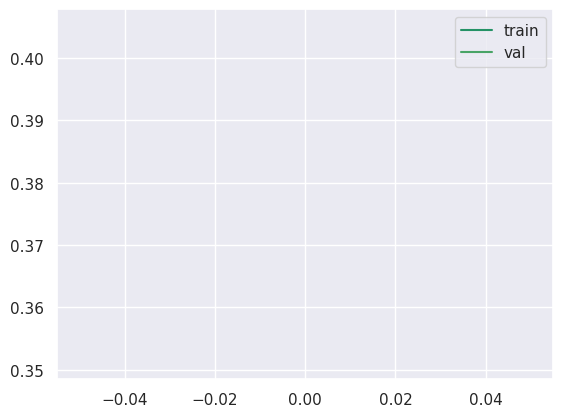

Валидация на эпохе: 1: 100%|██████████| 157/157 [00:02<00:00, 53.18it/s]


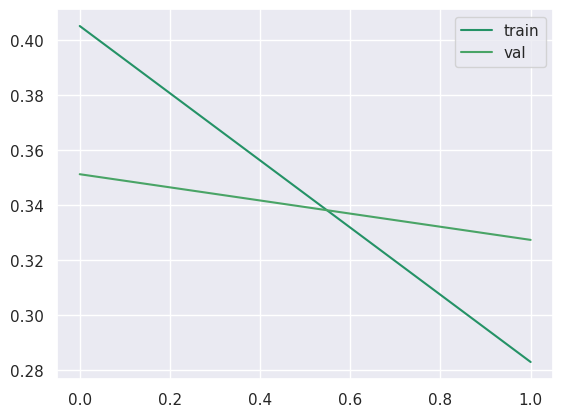

Валидация на эпохе: 2: 100%|██████████| 157/157 [00:02<00:00, 55.02it/s]


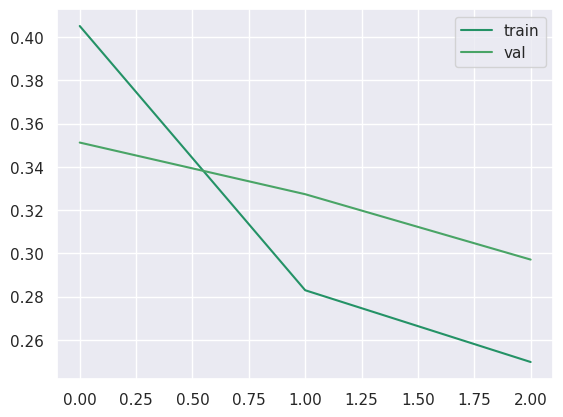

Валидация на эпохе: 3: 100%|██████████| 157/157 [00:03<00:00, 50.22it/s]


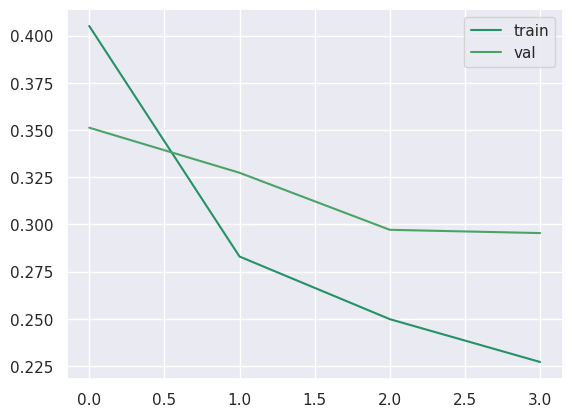

Валидация на эпохе: 4: 100%|██████████| 157/157 [00:02<00:00, 65.61it/s]


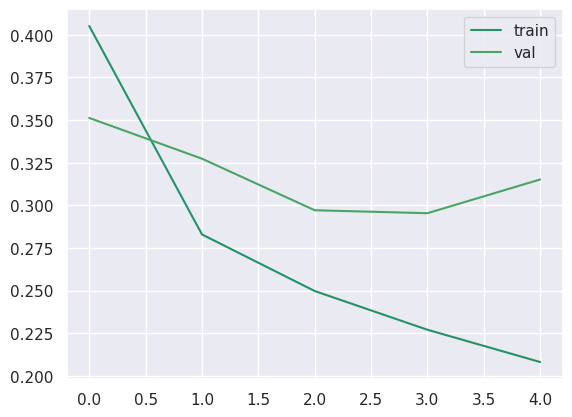

Валидация на эпохе: 5: 100%|██████████| 157/157 [00:02<00:00, 55.51it/s]


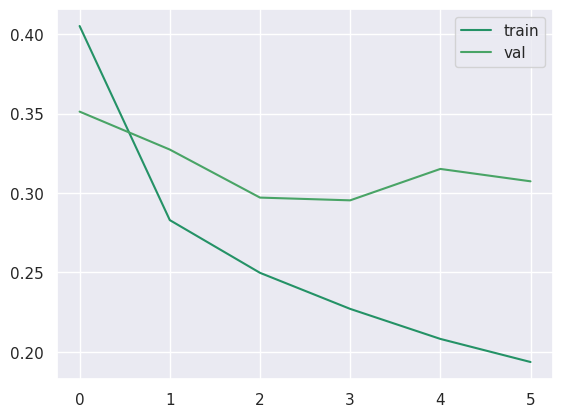

Валидация на эпохе: 6: 100%|██████████| 157/157 [00:02<00:00, 53.87it/s]


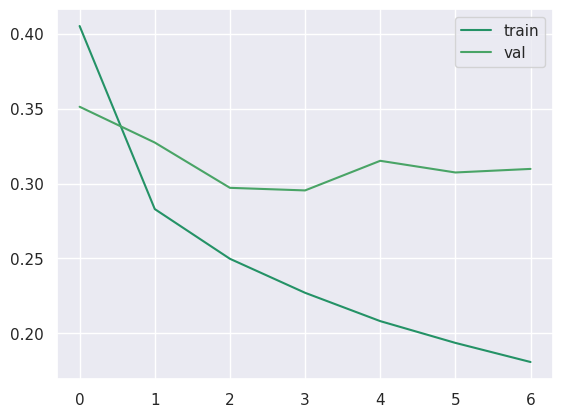

Валидация на эпохе: 7: 100%|██████████| 157/157 [00:03<00:00, 50.16it/s]


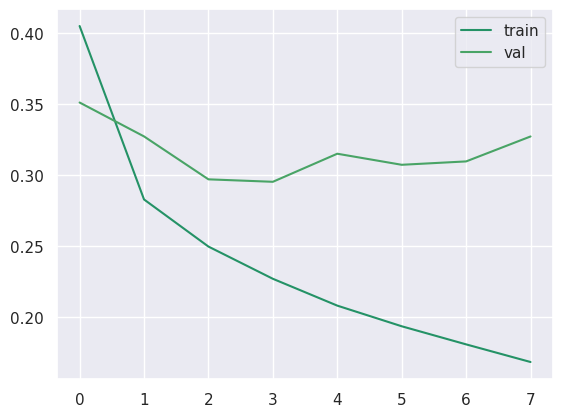

Валидация на эпохе: 8: 100%|██████████| 157/157 [00:02<00:00, 65.46it/s]


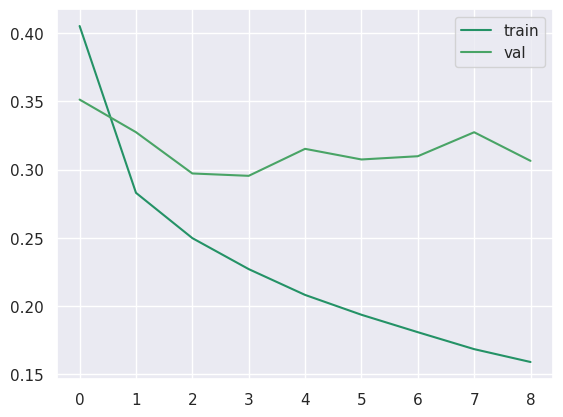

Валидация на эпохе: 9: 100%|██████████| 157/157 [00:02<00:00, 54.67it/s]


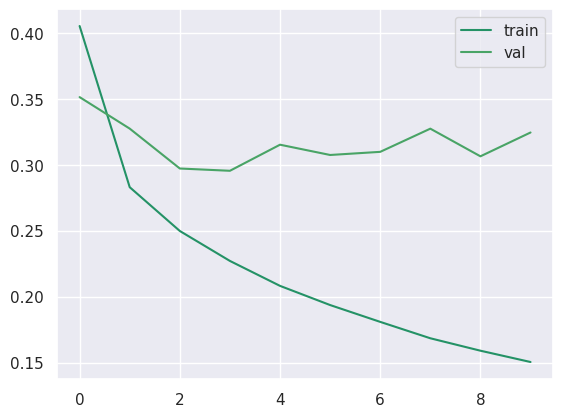

In [75]:
trainer(model,train_dataloader,eval_dataloader,optimizer,criterion)

In [76]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
model.load_state_dict(torch.load("model_3.pth", map_location=device))
model.eval()

CharLM(
  (embedding): Embedding(11842, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
evaluate(model,eval_dataloader) # Победа

0.9035999774932861

# Теперь попробуем модифировать начальную архитектуру

In [102]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  
        output, _ = self.rnn(embeddings)  

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] 
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) 
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  
        prediction = self.projection(self.non_lin(output))  

        return prediction

In [103]:
gru_model = CharLM_GRU(256,len(vocab),4)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru_model.parameters())

Валидация на эпохе: 0: 100%|██████████| 157/157 [00:04<00:00, 33.47it/s]


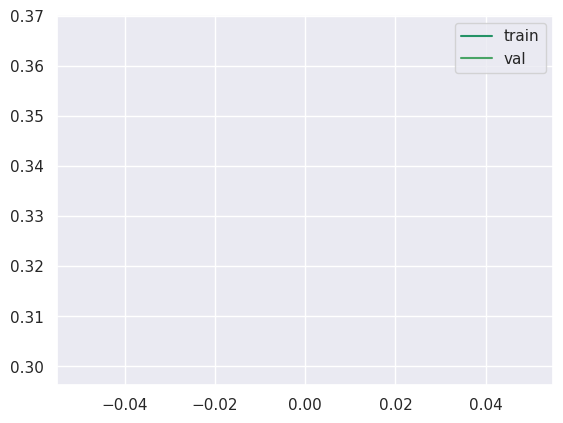

Валидация на эпохе: 1: 100%|██████████| 157/157 [00:04<00:00, 33.49it/s]


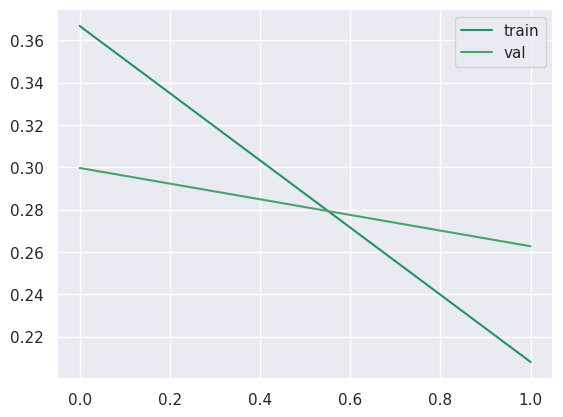

Валидация на эпохе: 2: 100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


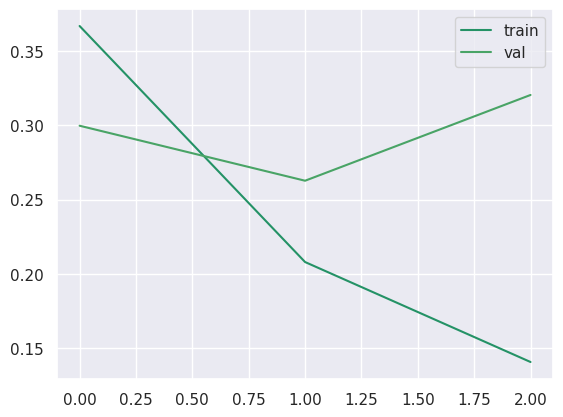

Валидация на эпохе: 3: 100%|██████████| 157/157 [00:05<00:00, 26.87it/s]


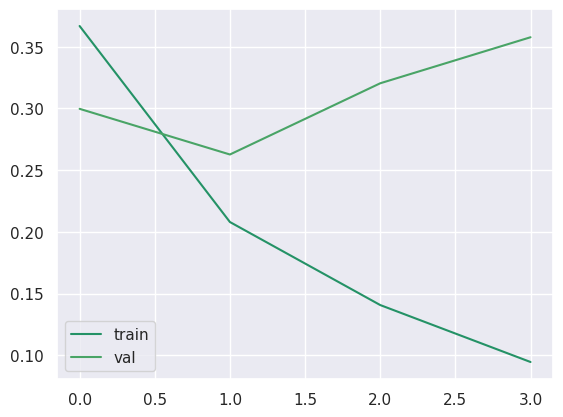

Обучение на эпохе: 4:   7%|▋         | 273/3750 [00:23<05:01, 11.55it/s]


KeyboardInterrupt: 

In [104]:
trainer(gru_model,train_dataloader,eval_dataloader,optimizer,criterion)

In [ ]:
#Лучший результат получил на первой эпохе, а дальше сильное переобучение идет
model = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
model.load_state_dict(torch.load("model_1.pth", map_location=device)) # Перезапиласи модель на первой эпохе
model.eval()

CharLM_GRU(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [120]:
evaluate(model,eval_dataloader) #гуд

0.9165999889373779

# Возьмем другую архитектуру

In [ ]:
class Model_rnn(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_class: int,):
        super().__init__()
        self.emb = nn.Embedding(vocab_size,hidden_dim)
        self.rnn = nn.GRU(hidden_dim,
                          hidden_dim,
                          batch_first= True,
                          num_layers = 2,
                          bias = True,
                          dropout = 0.2,
                          bidirectional = True)
        
        self.lin = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim // 2), 
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(hidden_dim // 4, num_class))
        
    def forward(self, input_batch) -> torch.Tensor:
        emd = self.emb(input_batch)
        output,_ = self.rnn(emd)
        x = output.mean(dim = 1)
        end = self.lin(x)

        return end

        

In [118]:
rnn_model = Model_rnn(256,len(vocab),4)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(rnn_model.parameters())

Валидация на эпохе: 0: 100%|██████████| 157/157 [00:17<00:00,  8.91it/s]


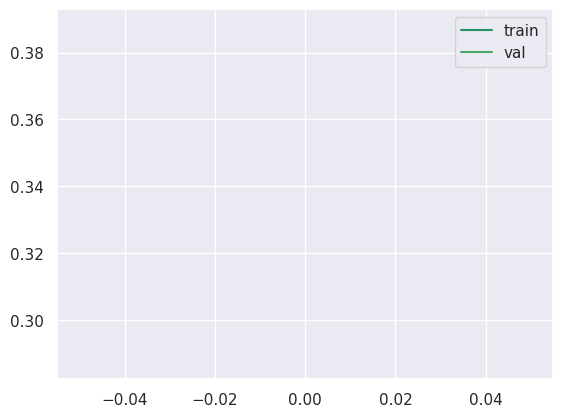

Валидация на эпохе: 1: 100%|██████████| 157/157 [00:13<00:00, 11.55it/s]


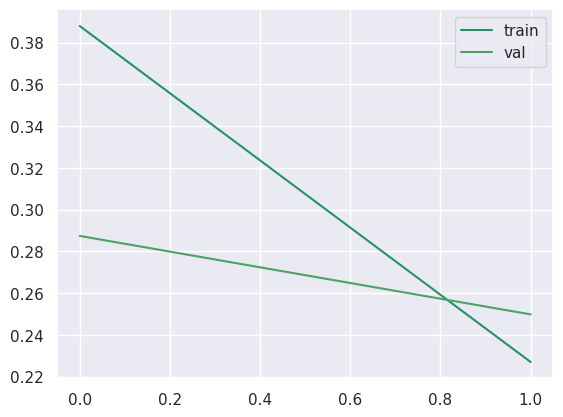

Валидация на эпохе: 2: 100%|██████████| 157/157 [00:14<00:00, 10.79it/s]


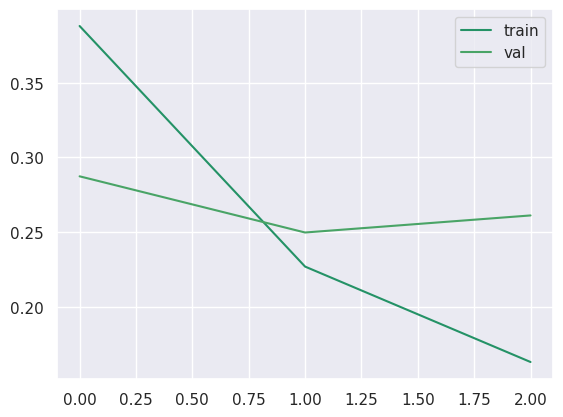

Валидация на эпохе: 3: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


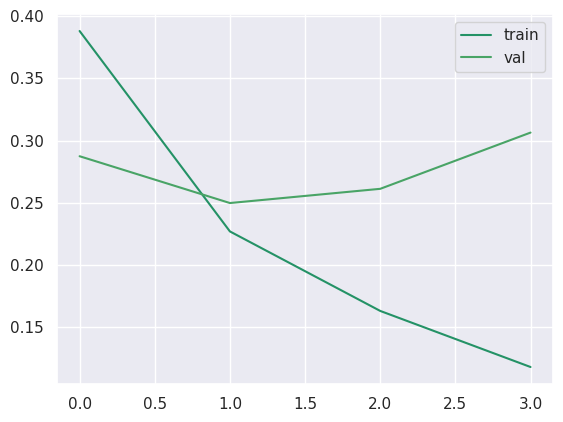

Валидация на эпохе: 4: 100%|██████████| 157/157 [00:13<00:00, 11.40it/s]


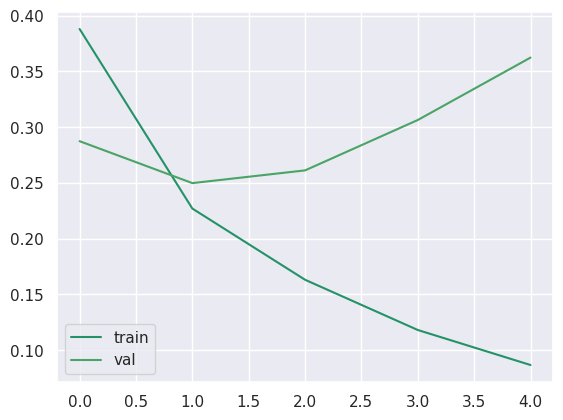

Обучение на эпохе: 5:  30%|███       | 1133/3750 [05:19<12:17,  3.55it/s]


KeyboardInterrupt: 

In [119]:
trainer(rnn_model,train_dataloader,eval_dataloader,optimizer,criterion)

In [ ]:
rnn_model = Model_rnn(hidden_dim=256, vocab_size=len(vocab),num_class=4).to(device)
rnn_model.load_state_dict(torch.load("model_1.pth", map_location=device)) # Перезаписали модель на первой эпохе шаге
rnn_model.eval()

Model_rnn(
  (emb): Embedding(11842, 256)
  (rnn): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [ ]:
evaluate(rnn_model,eval_dataloader) #Тоже хороший результат

0.9164000153541565

# Результат

### В итоге было проведенно 2 эксперимента. В первом случае были минимальные только в переходе от обычного RNN к GRU, что показало хорошие результаты на валидационной выборке. Во втором случае, я сильно изменил архтектуру и сам блок GRU. В итоге первый экспиремент показал лучшее качество(0.9165999889373779), но и вторая модель не сильно уступила(0.9164000153541565). Причем в обоих случаях модель начинала переобучаться после первой эпохи. Скорее всего это связано с шагом обучения, поэтому с ним стоило бы поиграться. Также с этой проблемой можно было бы бороться путем услиения вероятности dropout и добавления батч нормализации